In [25]:
import pandas as pd
import numpy as np
from copy import deepcopy
train = pd.read_csv("Train.csv",index_col=0)
test=pd.read_csv('Test.csv',index_col=0)

In [26]:
dlist=[]
err_list=[]
rulelist=[]

In [27]:
class Node:
    def __repr__(self):
        return "<Node Object with attribute "+str(self.attr)+" and bound "+str(self.bound)+" and decision "+str(self.decision)+">"
    def __init__(self, *args, **kwargs):
        try:
            self.parent = kwargs['parent']
        except:
            self.parent = None
        try:
            self.left = kwargs['left']
        except:
            self.left = None
        try:
            self.right = kwargs['right']
        except:
            self.right = None
        try:
            self.decision = kwargs['decision']
        except:
            self.decision = None
        try:
            self.attr = kwargs['attr']
        except:
            self.attr = None
        try:
            self.bound = kwargs['bound']
        except:
            self.bound = None

In [28]:
class Rule:
    def __repr__(self):
        if(self.dec):
            sign='>'
        else:
            sign='<='
        return "<" + str(self.attr)+" " + sign+str(self.val)+">"
    def __init__(self,attr,dec,val):
        self.attr=attr
        self.val=val
        self.dec=dec

In [29]:
def regressiontree():
    list_attr = train.columns.to_numpy()[:-1].tolist()
    root = Node()
    rule=[]
    d= split(train, root, 'left', list_attr,rule,-1)
    return (root,train,test,d)

In [30]:
def LS_ERROR(train, list_attr):
    input_train = train[list_attr]
    if(len(input_train.drop_duplicates())<=1):
        return 0
    else:
        #t = type(train['csMPa'][0])
        m = train['csMPa'].mean()
        ERROR = 0
        #print(len(train))
        for i in train.index:
            t=type(i)
            ERROR = ERROR + (train['csMPa'][i] - m)**2
        return ERROR

In [31]:
def WEIGHTED_LS(left, right, list_attr):
    lls = LS_ERROR(left, list_attr)
    rls = LS_ERROR(right, list_attr)
    return ((lls*len(left) + rls*len(right))/(len(left)+len(right)))

In [32]:
def split(root_train, parent, side, list_attr,rule,depth):
    newrule=deepcopy(rule)
#     print(newrule)
    a = Node(parent=parent)
    d=depth+1
    input_train = root_train[list_attr]
    if(LS_ERROR(root_train, list_attr) == 0):
        if(side == 'left'):
            parent.left = a
        else:
            parent.right = a
        rulelist.append(newrule)
        return d
    MIN_VAR = np.inf
    attr=None
    bound=0
    left=pd.DataFrame(columns=['cement','slag','flyash','water','superplasticizer','coarseaggregate','fineaggregate','age'])
    right=pd.DataFrame(columns=['cement','slag','flyash','water','superplasticizer','coarseaggregate','fineaggregate','age'])
    for attribute in list_attr:
        valid_set = root_train[attribute].unique().tolist()
        valid_set.sort()
        l =len(valid_set)
        for i in range(0,l-1):
            left_temp = root_train[root_train[attribute]<=valid_set[i]]
            right_temp = root_train[root_train[attribute]>valid_set[i]]
            v =WEIGHTED_LS(left_temp, right_temp, list_attr)
            if(v<MIN_VAR):
                left = left_temp
                right = right_temp
                attr = attribute
                bound = (valid_set[i]+valid_set[i+1])/2
                MIN_VAR = v
    a.attr = attr
    a.bound = bound
    if(side == 'left'):
        parent.left = a
    else:
        parent.right = a
    rulenode=Rule(attr,0,bound)
    newrule.append(rulenode)
    d1=split(left, a, 'left', list_attr,newrule,d)
    newrule=deepcopy(rule)
    rulenode=Rule(attr,1,bound)
    newrule.append(rulenode)
    d2=split(right, a, 'right', list_attr,newrule,d)
    return max(d1,d2)

In [33]:
(root,train,test,depth)=regressiontree()
print("Maximum depth of the tree=",depth)

Maximum depth of the tree= 13


In [34]:
for i in range(0,len(rulelist)):
    print(rulelist[i])
    print()

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag <=6.8>, <cement <=250.9>, <cement <=230.85>, <cement <=203.64999999999998>]

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag <=6.8>, <cement <=250.9>, <cement <=230.85>, <cement >203.64999999999998>]

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag <=6.8>, <cement <=250.9>, <cement >230.85>, <cement <=249.55>]

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag <=6.8>, <cement <=250.9>, <cement >230.85>, <cement >249.55>]

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.2

In [46]:
def shall_prune(rule,err,l):
    mini=-1
    minerr=err
    for i in range(0,l):
        df=test
        traindf=train
        j=0
        while(j<l):
            if(i==j):
                j=j+1
                continue
            else:
                temprule=rule[j]
                if(temprule.dec):# form subset of test samples and training samples excluding the last condition
                    traindf=traindf[traindf[temprule.attr]>temprule.val]
                    df=df[df[temprule.attr]>temprule.val]
                else:
                    traindf=traindf[traindf[temprule.attr]<=temprule.val]
                    df=df[df[temprule.attr]<=temprule.val]
                j=j+1
        df.reset_index(drop=True,inplace=True)
        m=traindf['csMPa'].mean()
        l2=df.shape[0]
        error=np.inf
        if(l2>0):
            error=0
            for k in range(0,l2):
                error=error+(m-df['csMPa'][k])**2
            error=error/l2
        if(error<=minerr):
            mini=i
            error=minerr
    flag=0
    if(mini>=0):
        flag=1
    return (flag,mini,minerr)   

In [47]:
def prune():
    l=len(rulelist)
    ammendlist=deepcopy(rulelist)
    for i in range(0,l):# access individual rules
        rule=ammendlist[i]
#         print(rule)
# start from last rule
        while(len(rule)):
            df=test
            traindf=train
            j=len(rule)
            for k in range(0,j):
                temprule=rule[k]
                if(temprule.dec):# form subset of test samples and training samples excluding the last condition
                    traindf=traindf[traindf[temprule.attr]>temprule.val]
                    df=df[df[temprule.attr]>temprule.val]
                else:
                    traindf=traindf[traindf[temprule.attr]<=temprule.val]
                    df=df[df[temprule.attr]<=temprule.val]
            df.reset_index(drop=True,inplace=True)
            m=traindf['csMPa'].mean()
#             print("Mean1=",m)
            l2=df.shape[0]
            err=np.inf
            if(l2>0):
                err=0
                for k in range(0,l2):
                    err=err+(m-df['csMPa'][k])**2
                err=err/l2
#             print("Error1=",err1)# error without pruning
            (flag,ind,lserr)=shall_prune(rule,err,j)# returns the precondition that reduces maximum error
            acclist[i]=lserr
            if(flag):
                print('Pruned')
                rule.pop(ind)# pop the rule from the list
            else:
                break
#         print()
    return ammendlist

In [48]:
ammendlist=prune()

Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned

Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned

Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned
Pruned

IndexError: list assignment index out of range

In [49]:
for i in range(0,len(ammendlist)):
    if(len(ammendlist[i])<len(rulelist[i])):
        print(ammendlist[i])

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <slag <=6.8>, <cement <=250.9>, <cement <=230.85>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <slag <=6.8>, <cement <=250.9>, <cement <=230.85>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag >6.8>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag >6.8>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <w

In [50]:
newlist=[] # this code snippet removes redundant rules
for i in ammendlist:
    flag1=True
    for j in newlist:
        flag2=True
        if(len(i)==len(j)):
            l=len(i)
            for k in range(0,l):
                if(i[k].attr == j[k].attr):
                    if(i[k].dec == j[k].dec):
                        if(i[k].val == j[k].val):
                            flag2=True
                        else:
                            flag2=False
                            break
                    else:
                        flag2=False
                        break
                else:
                    flag2=False
                    break
        else:
            flag2=False
        if(flag2):
            flag1=False
            break
    if(flag1):
        newlist.append(i)

In [51]:
for i in range(0,len(newlist)):
    print(newlist[i])

[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <slag <=6.8>, <cement <=250.9>, <cement <=230.85>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag <=6.8>, <cement >250.9>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag >6.8>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <water <=188.9>, <coarseaggregate <=1054.25>, <coarseaggregate <=1006.3499999999999>, <slag >6.8>, <cement >169.9>, <flyash <=172.95>, <cement >191.55>, <cement >219.35>]
[<cement <=263.25>, <age <=42.0>, <age <=21.0>, <age <=10.5>, <coarseaggregate <=1054.25>, <coarseaggregate >1006.349999

In [52]:
def accuracy():
    acclist=[]
    for i in range(0,len(newlist)):
        rule=newlist[i]
        j=len(rule)
        df=test
        traindf=train
        err=0
        for k in range(0,j):
            temprule=rule[k]
            if(temprule.dec):# form subset of test samples and training samples excluding the last condition
                traindf=traindf[traindf[temprule.attr]>temprule.val]
                df=df[df[temprule.attr]>temprule.val]
            else:
                traindf=traindf[traindf[temprule.attr]<=temprule.val]
                df=df[df[temprule.attr]<=temprule.val]
        df.reset_index(drop=True,inplace=True)
        m=traindf['csMPa'].mean()
        l2=df.shape[0]
        if(l2<=0):
            acclist.append(np.inf)
            continue
        err=0
        for k in range(0,l2):
            err=err+(m-df['csMPa'][k])**2
        err=err/l2
        acclist.append(err)
    return acclist
acclist=accuracy()

In [56]:
len(acclist)

537

In [57]:
tuples=[]
for i in range(0,len(acclist)):
    tuples.append((newlist[i],acclist[i]))

In [58]:
tuples.sort(key=lambda x:x[1])

In [59]:
tuples

[([<cement <=263.25>,
   <age <=42.0>,
   <age >21.0>,
   <slag <=43.650000000000006>,
   <water <=166.3>,
   <cement <=203.35>,
   <cement <=156.5>,
   <cement <=145.8>],
  0.0),
 ([<cement <=263.25>,
   <age <=42.0>,
   <age >21.0>,
   <slag <=43.650000000000006>,
   <water >166.3>,
   <cement <=165.55>,
   <water <=183.2>,
   <water <=181.3>,
   <flyash <=175.0>,
   <cement <=139.9>],
  0.0),
 ([<cement <=263.25>,
   <age <=42.0>,
   <age >21.0>,
   <slag <=43.650000000000006>,
   <water >166.3>,
   <cement <=165.55>,
   <water <=183.2>,
   <water <=181.3>,
   <flyash >175.0>,
   <superplasticizer <=14.5>,
   <cement <=157.5>,
   <cement >147.5>],
  0.0),
 ([<cement <=263.25>,
   <age <=42.0>,
   <age >21.0>,
   <slag <=43.650000000000006>,
   <water >166.3>,
   <cement <=165.55>,
   <water >183.2>,
   <coarseaggregate >945.0>,
   <cement <=153.2>],
  0.0),
 ([<cement <=263.25>,
   <age <=42.0>,
   <age >21.0>,
   <slag >43.650000000000006>,
   <water <=183.6>,
   <cement <=163.5>,


In [60]:
def accvsdepth():
    l=len(rulelist)
    for i in range(0,depth+1):
        dlist.append(i)
        err=0
        for j in range(0,l):
            df=test
            traindf=train
            rule=rulelist[j]
            y=len(rule)
            x=min(y,i+1)
            for k in range(0,x):
                temprule=rule[k]
                if(temprule.dec):# form subset of test samples and training samples excluding the last condition
                    traindf=traindf[traindf[temprule.attr]>temprule.val]
                    df=df[df[temprule.attr]>temprule.val]
                else:
                    traindf=traindf[traindf[temprule.attr]<=temprule.val]
                    df=df[df[temprule.attr]<=temprule.val]
            df.reset_index(drop=True,inplace=True)
            m=traindf['csMPa'].mean()
#             print("Mean1=",m)
            l2=df.shape[0]
            if(l2<=0):
                err=np.inf
            else:
                err1=0
                for k in range(0,l2):
                    err1=err1+(m-df['csMPa'][k])**2
                err=err+err1
        err=err/test.shape[0]
        err_list.append(err)

In [61]:
accvsdepth()

In [62]:
dlist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [74]:
errlist=[]
for i in err_list:
    if(i==np.inf):
        errlist.append(90000)
    else:
        errlist.append(i)

In [75]:
test.shape[0]

309

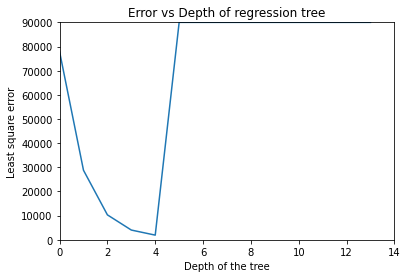

In [76]:
import matplotlib.pyplot as plt
plt.plot(dlist,errlist)
plt.xlabel('Depth of the tree')
plt.xlim([0,14])
plt.ylim([0,90000])
plt.ylabel('Least square error')
plt.title('Error vs Depth of regression tree')
plt.show()

In [79]:
flag=True
for i in range(1,14):
    if(errlist[i]>errlist[i-1]):
        print("Depth at which the model overfits=",i)
        flag=False
        break
if(flag):
    print("The model does not overfit")

Depth at which the model overfits= 5


In [80]:
print(np.inf)

inf
